<a href="https://colab.research.google.com/github/seyhosseini/AML-AVGAN-22/blob/main/Phase2_Lung_Segmentation_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> <font color = Olive > PHASE 2 </font>
## <b> <font color = Olive > Authors(s): </font>Armando Revelez, Nat Rojvachiranonda
## <b> <font color = Olive > Contributor(s): </font> Soheil Hosseini
## <b> <font color = Olive> Course: </font> AML ECE5995
## <font color = Olive> Project: </font> Lung Segmentation from CT Scan using GANs</b>


#<b> <font color = olive> Step 0 </font>: Unet Model & GAN Approach <font color=red> </b>

### <b> <font color = maroon> Phase 1: UNet Architecture </font> </b>
<font color = grey>* *ORIGINAL PAPER IMPLEMENTATION* *</font>
* Image input: 1 channel **->** Sequential Encoder Stages **->** Image Size Reduction by  ~$2^4$: 1024 Channels
* Reduced Image: 1024 channels **->** Sequential Decoder Stages **->** Resampled/Size Image ~$2^4$: 2 output channels 
* Encoder Outputs **->** Concatenate(Encoder Output, Prev Resample & Resize) **->** Decoder Input 
* This bridge connects what is called a <font color = red> <b> Semantic Gap </b> </font>
  * Semantic Definition - <font color = teal> "Relating to meaning in language or logic" </font>


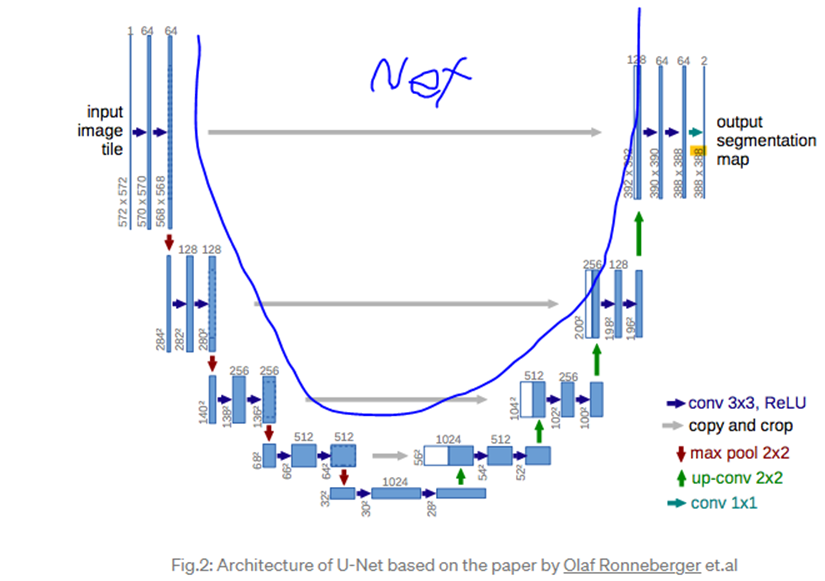

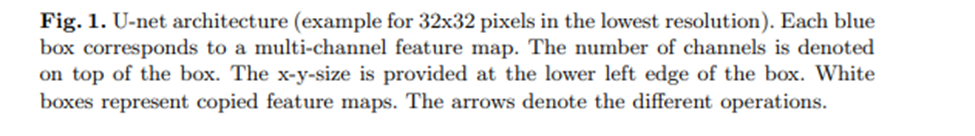

### <b> <font color = olive> Phase 2: UNet -> GAN Implementation </font> </b>
<font color = grey>* *IDEA BASED ON LECTURE MATERIALS & RESEARCH SOURCES, HW & PROVIDED EXAMPLES* *</font>
* UNet is a encoder-decoder based architecture that compresses <font color =mediumseagreen> **Medical Images** </font> information and rebuilds them into <font color =Midnightblue > **Image Segmentations (B/W masks)** </font>
* In a GAN application an VAE inspired UNet can act as the <font color = lightsteelblue> **generator** </font> producing noisy/distorted versions of predicted mask segmentations
* A <font color = coral> **discriminator** </font> architecture will be needed to compare images/label pairs to decide on real/fake segmentations. 
* Feedback is provided through training until UNet based Generator can confidently / accurately produce "Labels" of its input data


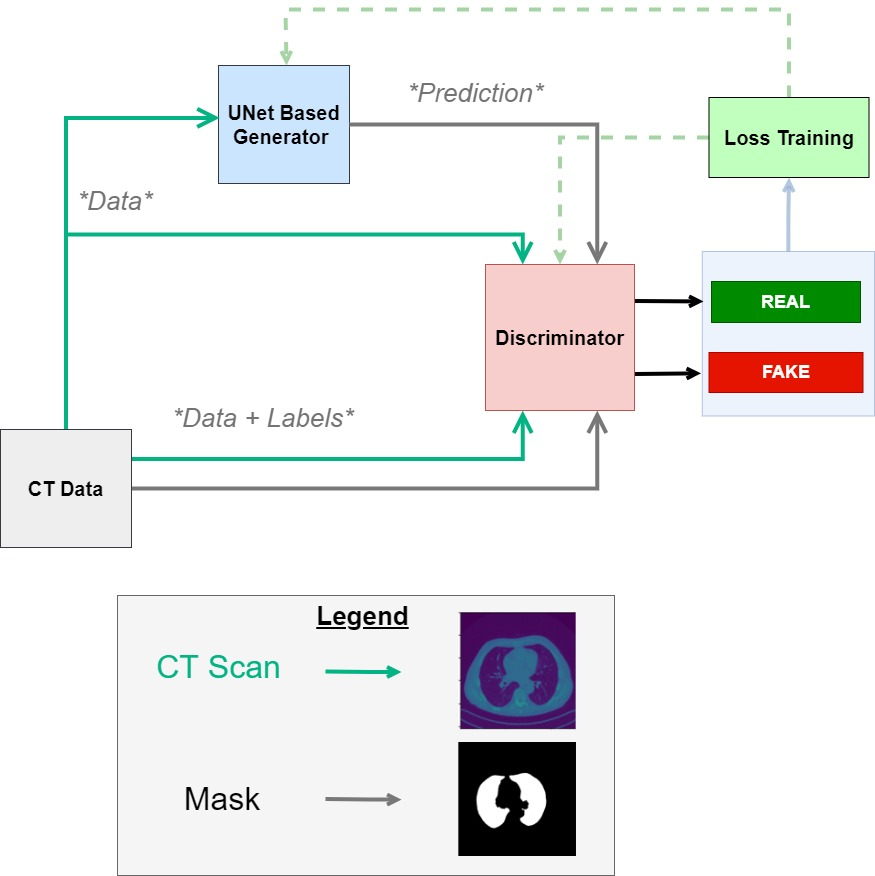

#<b> <font color = olive> Step 1 </font> : Create UNet CNN Pytorch definition<font color=red> </b>




* Derived from Unet implementation (https://github.com/zhixuhao/unet/blob/master/model.py) implemented with Keras, and the above visual of UNet from it's original research paper

### <b> <font color = green>Aim to produce segmented images from the network </font> </b>
* Data  5 CT Scans:
  * (<font color = red> 512 x 512 </font>) Voxels * (<font color = red> 355 </font> ) Slices Tall  
* Training:
  * Compare network output to labels (Provided Segmentaitons)


### <b> <font color = green>IMPORTS BLOCK</font> </b>

In [ ]:
# ---- PRELIMINARY IMPORTS ---- #

# Image stuff imports
# !pip install NiBabel

# Math import
import math

# sklearn
from sklearn.model_selection import train_test_split

# torch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# torch vision
import torchvision
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
from PIL import Image

# Supporting Libraries
import gdown
import os
import numpy as np
import matplotlib.pyplot as plt

# nibabel for converting images
import nibabel as nib
from google.colab import files


Collab Pro Stuff

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May  1 19:24:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## <b> <font color = olive> UNet Definition Pytorch Definition  </b></font>




### <font color = maroon> **Phase 1:** </font>V2 implementation to train with 512 x 512 masks  


In [ ]:
########################################################################################################################################################################
# --- CNN CLASS DEFINITION --- #

"""
 # ---- PHASE 1: V2 IMPLMENTATION ---- #
 #:v2
 # Description: 
 # ... This version alters the convolutional blocks to rebuild an image of the same size as the original.
 # ... This caters to an attempt at image segmenatation based on the UNet Architecture
"""
class UNet_V2(nn.Module):

  ###----------------------------------- CLASS CONSTRUCTOR -----------------------------------###
  def __init__(self):
    super(UNet_V2, self).__init__()

    ####### DROPOUT REFERNCE #######
    self.drop1 = nn.Dropout2d(p = .15, inplace = False)

    ###------------------- ENCODER STAGES ---------------- ###
    ######## ENCODER BLOCK 1 ########
    self.ENCODER_BL1 = unet_block(1,64,2)
    self.MAXPOOL_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    ######## ENCODER BLOCK 2 ########
    self.ENCODER_BL2 = unet_block(64,128,2)
    self.MAXPOOL_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 3 ########
    self.ENCODER_BL3 = unet_block(128,256,2)
    self.MAXPOOL_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    ######## ENCODER BLOCK 4 ########
    self.ENCODER_BL4 = unet_block(256,512,2)
    self.MAXPOOL_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 5 ########
    self.ENCODER_BL5 = unet_block(512,1024,2)
    
    ###------------------- DECODER STAGE -------------------###
    # TRANSITION #
    self.UPCONV_1 = upconv(1024,512)
    ######## DECODER BLOCK 1 ########
    self.DECODER_BL1 = unet_block(1024,512,2)
    self.UPCONV_2 = upconv(512,256)
    ######## DECODER BLOCK 2 ########
    self.DECODER_BL2 = unet_block(512,256,2)
    self.UPCONV_3 = upconv(256,128)
    ######## DECODER BLOCK 3 ########
    self.DECODER_BL3 = unet_block(256, 128,2)
    self.UPCONV_4 = upconv(128,64)
    ####### DECODER BLOCK 4 ########
    self.DECODER_BL4 = unet_block(128,64,2)
    ####### OUTPUT CONVOLUTION ########
    self.conv_END = nn.Sequential(
      nn.Conv2d(64, 1, kernel_size=1,  dilation = 1, stride=1, padding=0)
    ) 

    # Weight initialization
    self._initialize_weights()
  
  ###----------------------------------- FORWARD FUNCTION -----------------------------------###
  def forward(self, x):

    """
    KEY:
    x# -> input/output (x input -> x2 output, x2 input -> x3 output)
    u# -> Up convolution output, # correlates to convolution number NOT X number (x# input -> u# output) 
    x## -> Copy and crop with 1st # = x# encoder output, 2nd # = u# upconvolution output
    """ 

    ###------------- ENCODER STAGE PASSTHROUGH --------------###
    # print("Before Encoder 1: ", x.shape)
    x1 = self.ENCODER_BL1(x)
    # print("After Encoder 1: ", x1.shape)
    m1 = self.MAXPOOL_1(x1)
    # print("After Maxpool 1: ", m1.shape)

    # print("Before Encoder 2: ", m1.shape)
    x2 = self.ENCODER_BL2(m1)
    # print("After Encoder 2: ", x2.shape)
    m2 = self.MAXPOOL_2(x2)
    # print("After Maxpool 2: ", m2.shape)

    # print("Before Encoder 3: ", m2.shape)
    x3 = self.ENCODER_BL3(m2)
    # print("After Encoder 3: ", x3.shape)
    m3 = self.MAXPOOL_3(x3)
    # print("After Maxpool 3: ", m3.shape)

    # print("Before Encoder 4: ", m3.shape)
    x4 = self.ENCODER_BL4(m3)
    # print("After Encoder 4: ", x4.shape)
    m4 = self.MAXPOOL_4(x4)
    # print("After Maxpool 4: ", m4.shape)

    # print("Before Encoder 5: ", m4.shape)
    x5 = self.ENCODER_BL5(m4)
    # print("After Encoder 5: ", x5.shape)

    ###------------- DECODER STAGE PASSTHROUGH --------------###
    # print("Before UpConv: ", x5.shape)
    u1 = self.UPCONV_1(x5) 
    # print("After UpConv: ", u1.shape)

    # ENCODER OUTPUT x4 + UNCONV u1
    x41 = copy_crop(x4,u1)

    # print("Before Decoder 1: ", x41.shape)
    x6 = self.DECODER_BL1(x41)
    # print("After Decoder 1: ", x6.shape)

    # print("Before UpConv2: ", x6.shape)
    u2 = self.UPCONV_2(x6)
    # print("After UpConv2: ", u2.shape)

    # ENCODER OUTPUT x3 + UNCONV u2
    x32 = copy_crop(x3,u2)

    # print("Before Decoder 2: ", x32.shape)
    x7 = self.DECODER_BL2(x32)
    # print("After Decoder 2: ", x7.shape)

    # print("Before UpConv3: ", x7.shape)
    u3 = self.UPCONV_3(x7)
    # print("After UpConv3: ", u3.shape)

    # ENCODER OUTPUT x2 + UNCONV u3
    x23 = copy_crop(x2,u3)

    # print("Before Decoder 3: ", x23.shape)
    x8 = self.DECODER_BL3(x23)
    # print("After Decoder 3: ", x8.shape)

    # print("Before UpConv4: ", x8.shape)
    u4 = self.UPCONV_4(x8)
    # print("After UpConv3: ", u4.shape)

    # ENCODER OUTPUT x1 + UNCONV u4
    x14 = copy_crop(x1,u4)
    
    # print("Before Decoder 4: ", x14.shape)
    x9 = self.DECODER_BL4(x14)
    # print("After Decoder 4: ", x9.shape)

    x_out = self.conv_END(x9)
    # print("After final convolution: ", x_out.shape)

    
    # PASS THROUGH ORDER:
    # x -> x1 -> m1 -> x2 -> m2 -> x3 -> m3 -> x4 -> m4 -> x5 -> u1 -> x41 -> x6 -> u2 -> x32 -> x7 -> u3 -> x23 -> x8 -> u4 -> x14 -> x9 -> x_out

    return x_out


    ###----------------------------------- Weight Initialization -----------------------------------###  
  def _initialize_weights(self) -> None:
    for module in self.modules():
        if isinstance(module, nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            # nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
            nn.init.zeros_(module.bias.data)


########################################################################################################################################################################
# --- HELPER FUNCTIONS --- #

"""
# Name: copy_crop
# Paramaters: Encoder output tensor, up convolution tensor
# Return: Decoder Input (Concatenated image)
# Details:
# ... When each semantic gap is bridged, it is described as a "Copy and crop".
# ... It copies the output of the encoder block, to be received and included in the decoding stage.
# ... The tensor from the encoder stage must have it's image dimension cropped to fit the up convolution, ....
# ... THE CHANNELS from the up convolution and encoder stage output ARE CONCATENATED. ...
# ... Each decoder stage eventually produces the segemnted output.
"""
def copy_crop(enc_out, up_conv):    

    # IF enc_out dim > up_conv dim -> trim encoder output to match up_conv
    # Trim the image dimensions to fit
    enc_out_crop = T.functional.crop(enc_out,
                                      0,0, # Crop from origin
                                      up_conv.shape[2], # up_conv.shape[1] == up_conv.shape[2], so enc_out is trimmed to these square dimensions
                                      up_conv.shape[2])
    
    # Concat = trimmed enc_out CHANNELS + up_conv CHANNELS 
    dec_in = torch.cat((up_conv,enc_out_crop),1)
   
    return dec_in

"""
# Name: unet_block
# Parameters: in/out channels, UNET version
# Return: Sequential encoder / decoder definition based on input channels / output channels
# Description: 
# ... UNet Encoder/Decoder block re-usable definition. 
# ... Each block reduces the image dimensions by 4, and halves the input channels.
"""
def unet_block(inchannels,outchannels,version):

  # PHASE 1 DEFINITION
  if version == 2:
    return nn.Sequential(
        nn.Conv2d(inchannels, outchannels, kernel_size=3, stride=1, padding=1, dilation =1),
        nn.ReLU(True),
        nn.Conv2d(outchannels, outchannels, kernel_size=3, stride=1, padding=1, dilation =1),
        nn.ReLU(True)
      ) 
    
  # PHASE 2 OPTIONAL DEFINITION?
  elif version == 3:
    return nn.Sequential(
        nn.Conv2d(inchannels, outchannels, kernel_size=3, stride=1, padding=1, dilation =1),
        nn.ReLU(True),
        nn.Conv2d(outchannels, outchannels, kernel_size=3, stride=1, padding=1, dilation =1),
        nn.ReLU(True)
      ) 
    
    #Else it just breaks...
    
"""
# Name: upconv
# Parameters: in/out channels
# Description: 
# ... Up-convolution consisting of a 2 x 2 convolution and an upsample.
"""
def upconv(inchannels,outchannels):
  return nn.Sequential(
        nn.Conv2d(inchannels, outchannels, kernel_size=2, stride=1, padding=1, dilation =2),
        nn.Upsample(scale_factor=2,mode ='bilinear',align_corners=False)
    )


### <font color = maroon><b> Phase 1: </b> </font> Efficiently condensed UNet definition (By Nat)

In [ ]:

"""
Generic UNet bloc
"""
class Block(nn.Module):
  def __init__(self,inCh,outCh):
    super(Block,self).__init__()

    self.conv1 = nn.Conv2d(inCh,outCh,kernel_size=3,padding='same')
    self.conv2 = nn.Conv2d(outCh,outCh,kernel_size=3,padding='same')

  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)

    return x

"""
Encoder Stage block
"""
class Enc(nn.Module):
  def __init__(self,channels=(1,64,128,256,512,1024)):
    super(Enc,self).__init__()

    self.encBlocks = nn.ModuleList([Block(channels[i],channels[i+1]) for i in range(len(channels)-1)])

    self.pool = nn.MaxPool2d(kernel_size=2)

  def forward(self,x):
    trans = []
    for blocks in self.encBlocks:
      x = blocks(x)
      trans.append(x)
      x = self.pool(x)

    return trans

"""
Decoder Stage block
"""
class Dec(nn.Module):
  def __init__(self,channels=(1024,512,256,128,64)):
    super(Dec,self).__init__()
    self.channels = channels
    self.upconv = nn.ModuleList([nn.ConvTranspose2d(channels[i],channels[i+1],kernel_size=2,stride=2) for i in range(len(channels)-1)])
    self.decBlocks = nn.ModuleList([Block(channels[i],channels[i+1]) for i in range(len(channels)-1)])

  def forward(self,x,encFeat):
    for i in range(len(self.channels)-1):
      x = self.upconv[i](x)
      encTrans = self.crop(encFeat[i],x)
      x = torch.cat([x,encTrans],dim=1)
      x = self.decBlocks[i](x)
    return x

  def crop(self,encTrans,x):
    a,b,H,W = x.shape
    encTrans = T.CenterCrop([H,W])(encTrans)
    return encTrans

"""
Condensed Unet block definition
"""
class UNet(nn.Module):
  def __init__(
      self,
      encChannels = (1,64,128,256,512,1024),
      decChannels = (1024,512,256,128,64),
      noClass = 1,
      outSize = (572,572)
  ):
    super(UNet,self).__init__()
    
    self.enc = Enc(encChannels)
    self.dec = Dec(decChannels)
    self.head = nn.Conv2d(decChannels[-1],noClass,kernel_size=1,padding='same')
    self.outSize = outSize

  def forward(self,x):
    encTrans = self.enc(x)
    out = self.dec(encTrans[::-1][0], encTrans[::-1][1:])
    out = self.head(out)
    
    # out = F.interpolate(out,self.outSize)
    return out

### <font color = Olive> **Phase 2:** </font> Descriminator Definition   <font color = red> 
TODO:  </font> Modify this discriminator to work with data

In [ ]:
########################################################################################################################################################################
# --- CNN CLASS DEFINITION --- #

"""
 # ---- PHASE 2: Descriminator IMPLMENTATION ---- #
 #:descriminator
 # Description: 
 # ... 
"""
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()

        channels = len(im_train)
        self.network = nn.Sequential(
            
          # Encoder block
          nn.Conv2d(2, 32, kernel_size = 3, padding = 1),
          nn.ReLU(),
          nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
      
          # Encoder block
          nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
          nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          
          # Encoder block
          nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
          nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          
          nn.Flatten(),
          nn.Linear(1048576,channels*4),
          nn.ReLU(),
          nn.Linear(channels*4,channels*2),
          nn.ReLU(),
          nn.Linear(channels*2,channels)
        )
    
    def forward(self, x):
      x = self.network(x)
      return x


### <font color = red> Dont run this section! (Original scratch testing ) </font>
### **Pytorch function testing & Network pass through verificaiton** 

In [ ]:
"""
# ------------------------------------------------- #
# ------------  PYTORCH TESTING BLOCK  ------------ #
"""
import torch.nn as nn
import torch.nn.functional as F

m1 = nn.Conv2d(in_channels =6, out_channels = 32,kernel_size = 4, stride=1,padding = 1)
m2 = nn.Conv2d(in_channels =6, out_channels = 12,kernel_size = 9, stride=1,padding = 3)
P = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

input = torch.randn(20, 6, 32,32) # Assume this is 4D?


output = m1(input)
output2 = P(input)
output3 = m2(input)

print(type(input))
print("\n Input tensor: \t\t\t",input.shape,
      "\n Conv2d kernal 3: \t\t",output.shape,
      "\n Conv2d kernal 6: \t\t",output3.shape,
      '\n MaxPool2D: \t\t\t',output2.shape)

<class 'torch.Tensor'>

 Input tensor: 			 torch.Size([20, 6, 32, 32]) 
 Conv2d kernal 3: 		 torch.Size([20, 32, 31, 31]) 
 Conv2d kernal 6: 		 torch.Size([20, 12, 30, 30]) 
 MaxPool2D: 			 torch.Size([20, 6, 16, 16])


# <font color = olive><b> Step 2</b> </font> : **Define dataloader class, load the CT/CTA images, create transforms, and generate training and testing sets.**

In [ ]:
"""
Custom Rotation transform: We need a fixed rotation on both images
"""
import torchvision.transforms.functional as TF
import random

class MyTransform():
    """Rotate by one of the given angles."""

    def __init__(self, angle = 30, vflip = 1, hflip = 1):
        self.angle = angle
        self.vflip = vflip
        self.hflip = hflip

    def setValues(self, angle, vflip, hflip):
        self.angle = angle
        self.vflip = vflip
        self.hflip = hflip

    def __call__(self, x):
        
        x = torch.unsqueeze(x, 0) # Need the leading dimension to perform a rotation
        x = TF.rotate(x, self.angle, fill = x[0, -1 ,-1].item()) # Fill the outer space with pixel on the uppermost corner (absolute background of CT) to avoid square edges in images
        if self.vflip: x = TF.vflip(x)
        if self.hflip: x = TF.hflip(x)
        return x

In [ ]:
"""
:data_loader
  PHASE 2 IMPLMENTATION 
   Class name: CT_Slices_Dataset
   Parameters:
      - CT_Scans             (array): List of refernce images save in memory 
      - Seg_Masks            (array): List of refernce images save in memory
      - testImageIndices     (list): List of image indices for training paired with masks
      - testMaskIndices      (list): List of masks indices for training  
      - XXXX CT_Scan_Dims    (tuple): Image X,Y (Slice dimensions) & Z (Number of slices/CT_Scan) dimensions 
      - TX_forms             (T.Compose): Series of transformations to be applied to image AND masks

   Description:
      - Based on the # of Images loaded into memory (len(CT_Scan))...
      ...retrieve/set a current image/mask. ...
      ...Index through the current image and mask until Z dim exceeded. ...
      ...Load next image/mask as current scan and index its slices.
"""

from matplotlib import image
import gc

class CT_Slices_Dataset(Dataset):

  # , CT_Scan_Dims
  def __init__(self, CT_Scans, Seg_Masks, testImageIndices, testMaskIndices, TX_forms = None):
    super(CT_Slices_Dataset, self).__init__()

    # New Idea: Load all images in memory first, then use this indexing idea
    self.ImageArrays =[]
    self.MaskArrays =[]

    # CT scans    
    self.CT_Scans = CT_Scans
    # CT Scan Seg_Masks
    self.Seg_Masks = Seg_Masks

    print("Loading & normalizing images...")
    for i in range(len(self.CT_Scans)):
      # Save temp values as tensors
      tempIVal = TF.to_tensor(nib.load(self.CT_Scans[i]).get_fdata())
      tempMVal = TF.to_tensor(nib.load(self.Seg_Masks[i]).get_fdata())

      # Image size actually varies, so cut them all to 355 for indexing purposes.
      tempIVal = tempIVal[:355]
      tempMVal = tempMVal[:355]

      # Append normalized tensors to list of image arrays
      self.ImageArrays.append(TF.normalize(tempIVal, torch.mean(tempIVal), torch.std(tempIVal) ))
      self.MaskArrays.append(TF.normalize(tempMVal, torch.mean(tempMVal), torch.std(tempMVal)))

      print("[NORMALIZED] Image: {imgname}:".format(imgname = self.CT_Scans[i]), tempIVal.shape)
      print("[NORMALIZED] Mask: {mskname}:".format(mskname = self.Seg_Masks[i]), tempMVal.shape)

      # Reduce RAM Stress: Remove references
      del(tempIVal)
      del(tempMVal)
      gc.collect()

    # Private variables to current CT_Scan & Seg_Mask 
    self.CT_Current = None
    self.Mask_Current =  None

    # The list of images we will be training through
    self.testImageIndices = testImageIndices
    self.testMaskIndices = testMaskIndices

    # EXPECTED DIM: Z, X, Y
    self.CT_Scan_Dims = self.ImageArrays[0].shape # Later set to .shape of image inport

    # Image indexing  
    self.Current_IND = -99 # Garbage starting value, so new index is always found from the begining
    self.MAX_IND = self.CT_Scan_Dims[0]*len(self.CT_Scans) # Later set by .shape on z dim

    # Transforms to apply
    self.TX_forms = TX_forms

  def __len__(self):
        # Length of iterable data is CT_Scan Zdim * Number of Scans
        return len(self.testImageIndices) # == len(self.testMaskIndices)

  """
  Training/Testing Split: List of values corresponding to image/masks indexes... (References)
  * References: Which saved image & mask pair do we load, and which slice do we sample

  Training loop iterates through TRAINING SET image and mask REFERENCE INDICES

    on .getItem(index of TRAINING SET list)
    ...
    get reference from (index of TRAINING SET list)
    ...
    Load in current image if needed
    Decide what slices we are sampling
    ...
    Return the specified slice of the specified image

  """
  def __getitem__(self, batch_index: int):

    # Index of training set
    setIndex = self.testImageIndices[batch_index]
    
    # UPDATE OR KEEP IMAGE/MASKS
    # LOGIC: If index in valid range - Either update or keep currently loaded image. Using Arithmetic sample desired image
    # ... Else index not in valid range, return images but with all zeros
    if setIndex < self.MAX_IND:
      
      tempIND = (setIndex - setIndex%self.CT_Scan_Dims[0])//self.CT_Scan_Dims[0] # Informs us what CT and mask to load
      # print(tempIND, self.Current_IND)
     
      #If the index has changed.. 
      if self.Current_IND != tempIND: 
        
        # UPDATE: Load new pair of scans and masks
        # self.CT_Current = np.swapaxes(nib.load(self.CT_Scans[tempIND]).get_fdata(),0,2)
        # self.Mask_Current =  np.swapaxes(nib.load(self.Seg_Masks[tempIND]).get_fdata(),0,2)
        self.CT_Current = self.ImageArrays[tempIND]
        self.Mask_Current =  self.MaskArrays[tempIND]

        # UPDATE: Change current image reference index
        self.Current_IND = tempIND

    else: # Catch if we go past the last value
      
      return torch.tensor(np.zeros_like(self.CT_Scan_Dims[1],self.CT_Scan_Dims[2])), torch.tensor(np.zeros_like(self.CT_Scan_Dims[1],self.CT_Scan_Dims[2]))

    # SLICE INDEX: Calculate slice of desired image based on wrapped modulus value
    sliceINDX = setIndex%self.CT_Scan_Dims[0] # RETRIEVE DESIRED SLICE

    # Generate random parameters to apply for transform: Angle, vflip, hflip
    paramArray = [random.choice([-45, -30, 0, 30, 45]), random.randint(0,1), random.randint(0,1)]
    self.TX_forms.setValues(paramArray[0],paramArray[1],paramArray[2])

    # TX_FORMS: Apply transforms if present
    if self.TX_forms == None:
      return self.CT_Current[sliceINDX], self.Mask_Current[sliceINDX]
    else: 
      # Apply transforms to BOTH this is needed for adequate training 
      return self.TX_forms(self.CT_Current[sliceINDX]), self.TX_forms(self.Mask_Current[sliceINDX])
    

### <font color = red> Dont run this section! (Original scratch testing ) </font>
### **Iterating through images testing** 

In [ ]:
Z_dim = 25
Total_Images = ["a","b","c","d","e"]
totalImages = len(Total_Images)

testArr = np.ndarray((Z_dim,4,4), dtype = int)

# Scans can be indexed from 0 to (Z dim-1) 
print(testArr[0].shape,testArr[Z_dim-1].shape)

# On index Z_dim -> Wraps value 0 to index NEXT IMAGE
# wrapVal = testArr.shape[0]
# for i in range(wrapVal*4):
#   print(i,i%wrapVal)

# Need to specify index depending on divided total
index = 30 # Indexes 0 - 154, 155 - 155*2-1, 155*2 - 155*3-1, 155*3 - 155*4-1, 155*4 - 155*5-1, 

# Arithmetic to generate image index from saved images depending on index
if index < Z_dim*len(Total_Images):
  imageIND = (index - index%Z_dim)//Z_dim
else: # Catch if we go past the last value
  imageIND = (Z_dim*len(Total_Images)-1 - (Z_dim*len(Total_Images)-1)%Z_dim)//5 

print(imageIND, Total_Images[imageIND])

imageIndices = []

for i in range(Z_dim*totalImages):
  imageIndices.append(i)

maskIndices = imageIndices

im_train, im_test, vs_train, vs_test = train_test_split(imageIndices,maskIndices,test_size=0.15,random_state=42)
print("Train image set: ", im_train)
print("Mask image set: ", vs_train)


(4, 4) (4, 4)
1 b
Train image set:  [114, 47, 78, 0, 26, 31, 67, 12, 24, 45, 108, 89, 73, 64, 15, 112, 22, 40, 81, 85, 30, 94, 55, 9, 33, 62, 25, 119, 28, 66, 122, 5, 65, 70, 39, 49, 35, 16, 68, 34, 115, 7, 118, 43, 95, 69, 100, 105, 8, 13, 109, 3, 17, 38, 72, 97, 6, 80, 107, 110, 54, 50, 83, 46, 84, 61, 121, 79, 98, 41, 58, 90, 48, 88, 120, 57, 75, 32, 117, 59, 63, 104, 37, 29, 111, 1, 52, 21, 2, 23, 103, 99, 87, 113, 74, 86, 82, 124, 20, 60, 71, 106, 14, 92, 51, 102]
Mask image set:  [114, 47, 78, 0, 26, 31, 67, 12, 24, 45, 108, 89, 73, 64, 15, 112, 22, 40, 81, 85, 30, 94, 55, 9, 33, 62, 25, 119, 28, 66, 122, 5, 65, 70, 39, 49, 35, 16, 68, 34, 115, 7, 118, 43, 95, 69, 100, 105, 8, 13, 109, 3, 17, 38, 72, 97, 6, 80, 107, 110, 54, 50, 83, 46, 84, 61, 121, 79, 98, 41, 58, 90, 48, 88, 120, 57, 75, 32, 117, 59, 63, 104, 37, 29, 111, 1, 52, 21, 2, 23, 103, 99, 87, 113, 74, 86, 82, 124, 20, 60, 71, 106, 14, 92, 51, 102]


## <font color = olive> Load & Create data </font>
* An idea: Modify data loader to sample images from data based on a differnt form of indexing. Like Image 1 - (indx 0 - 355), Image 2 - (indx 366 - 2*355).
  * In those particular ranges, Make current image belonging to that range, and feed slices to model. When the index surpasses the range. Make current image belonging to the next range. 


In [ ]:
""" 
Step 2: Load / Save data -> Colab files
"""

from google.colab import files

# ---- Quick helper function ---- #
def typeAndShape(input):
  print(type(input),input.shape)

# ---- Generate a list of image files ----- #
# Need to check if images need to be reloaded
# Also acts as references for reading the image and converting it to ndarray later on
numImages = 3

inputCTs = []
LungMasks = []

for i in range(numImages):
  inputCTs.append("I0"+str(i+1)+".nii.gz")
  LungMasks.append("M0"+str(i+1)+".nii.gz")
 
  print(inputCTs[i], LungMasks[i])
  print(os.path.exists(inputCTs[i]),os.path.exists(LungMasks[i]))

# ---- DATA IMPORTS ---- #
#### Adapted from Soheils provided boiler plate imports Images_Main.ipynb ####
for i in range(numImages):

  

  # If any of the images don't exist load them in again
  if(os.path.exists(inputCTs[i]) == False or os.path.exists(LungMasks[i]) == False ):    
    # Break the loop don't check again
    uploaded = files.upload()
    """
    The only way I could access the files from colab was by accessing the local onedrive share file and adding images to the session
    """
    for fn in uploaded.keys():
      # This will prompt for document upload on local machine
      print('User uploaded file "{name}" with length {length} bytes'.format( name=fn, length=len(uploaded[fn])))
    
    


I01.nii.gz M01.nii.gz
True True
I02.nii.gz M02.nii.gz
True True
I03.nii.gz M03.nii.gz
True True


## <font color = olive> Data Augmentations </font>



In [ ]:
from torch.nn.modules.activation import Tanh
    
# ---- DATA TRANSFORMATION ---- #

# CT_Scan_transforms =T.Compose(
#     [
#      # define your data augmentation HERE. You can start by uncomment the following line
#       # transforms.ToPILImage(),
#       T.ToTensor(),
#       T.RandomRotation(degrees = 30),
#       T.RandomVerticalFlip(),
#       # T.Normalize(CTmean,CTstd),
#       # transforms.Grayscale(),
#       # transforms.Resize(size = (324,324), interpolation= InterpolationMode.BILINEAR),
   
#      ])

CT_Scan_transforms = MyTransform()


##<font color = olive> Spltting of training & testing data</font>

In [ ]:
ref_Z_dim = np.swapaxes(nib.load(inputCTs[0]).get_fdata(),0,2)

imageIndices = []

# Generate refernces values to images & slices from 0 - Last Scan Slice
for i in range((ref_Z_dim.shape[0])*len(inputCTs)):
  imageIndices.append(i)

maskIndices = imageIndices


im_train, im_test, vs_train, vs_test = train_test_split(np.asarray(imageIndices),np.asarray(maskIndices),test_size=0.30,random_state=42)

print("Max index: ", (ref_Z_dim.shape[0])*len(inputCTs))
print("Random image references: ")
print("Set size", len(im_train))
print(im_train[:100], "... ", "\n",vs_train[:100], "... ")
print("Check for exceeding max")
print(im_train[im_train > (ref_Z_dim.shape[0])*len(inputCTs)])
print("Verify index per image (max/num images): ", ((ref_Z_dim.shape[0])*len(inputCTs))//len(inputCTs))

"""
Class name: CT_Slices_Dataset
   Parameters:
      - CT_Scans             (array): List of refernce images save in memory 
      - Seg_Masks            (array): List of refernce images save in memory
      - testImageIndices     (list): List of image indices for training paired with masks
      - testMaskIndices      (list): List of masks indices for training  
      - XXXX CT_Scan_Dims    (tuple): Image X,Y (Slice dimensions) & Z (Number of slices/CT_Scan) dimensions 
      - TX_forms             (T.Compose): Series of transformations to be applied to image AND masks
      
  def __init__(self, CT_Scans, Seg_Masks, testImageIndices, testMaskIndices, TX_forms = None):
"""
trainData = CT_Slices_Dataset(CT_Scans = inputCTs, Seg_Masks = LungMasks, testImageIndices = im_train, testMaskIndices = vs_train, TX_forms = CT_Scan_transforms)
trainLoader = DataLoader(trainData,shuffle=True)

testData = CT_Slices_Dataset(CT_Scans = inputCTs, Seg_Masks = LungMasks, testImageIndices = im_test, testMaskIndices = vs_test, TX_forms = CT_Scan_transforms)
testLoader = DataLoader(testData,shuffle=True)

Max index:  1065
Random image references: 
Set size 745
[   5  310  541  104   97  332  458  314  516  958  281  266  518  594
  864  560  966  576  118  965  250  425  285  855    9  999  196  668
   81  467  693  684  239  361  211  792  595  532  227  946  635  424
  979  177 1029  485  450  545  534  808  457    7 1017  155  357  597
  223  329  884  491  859  398  743  920  558  716 1028  628  566  585
  644  780  736  163  228  439 1054  212  845   79  148  302  420  405
 1010 1018   43  901  133  843  311  408  527  810  529  917  830    0
  360  382] ...  
 [   5  310  541  104   97  332  458  314  516  958  281  266  518  594
  864  560  966  576  118  965  250  425  285  855    9  999  196  668
   81  467  693  684  239  361  211  792  595  532  227  946  635  424
  979  177 1029  485  450  545  534  808  457    7 1017  155  357  597
  223  329  884  491  859  398  743  920  558  716 1028  628  566  585
  644  780  736  163  228  439 1054  212  845   79  148  302  420  405
 1

In [ ]:
# # Can we get stuff from this?

# # --------- NETWORK IN/OUT TESTING ------- #
# for i, image, labels in enumerate(trainLoader, 0):

# <font color = olive> <b> Step 2.5 </b> </font> : **Visualize the CT/CTA scans dataset, and UNet initial outputs.**


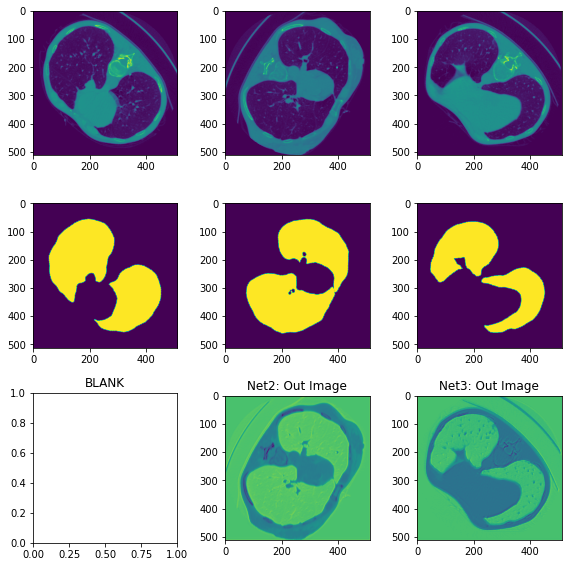

In [ ]:
import gc
from torch._C import dtype
""" 
Step 2.5: Visualize CT/CTA scans *If possible*
:input_data
"""

# Did this to re-update net everytime I tweaked optimizers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create two versions to test with input data
net2 = UNet_V2().to(device) # This version adds padding to match output

net3 = UNet().to(device) # This version made by Nat also idealizes the output but makes definition much smaller


# Quick visualization :)
fig ,ax = plt.subplots(3,3,figsize=(8,8))
fig.set_tight_layout(True)
# fig.suptitle("Scans(Row 0)     Masks(Row 1)     UNet_Outputs Test(Row 2)")
ax[2][0].set_title("BLANK")
ax[2][1].set_title("Net2: Out Image")
ax[2][2].set_title("Net3: Out Image")


# --------- NETWORK IN/OUT TESTING ------- #
for i, data in enumerate(trainLoader, 0):

  # Graph 4 instances of the input and label
  if i==3: break
  else:
    inputs, labels = data[0].to(device = device, dtype = torch.float), data[1].to(device = device, dtype = torch.float)

    ax[0][i].imshow(np.squeeze(np.squeeze(np.asarray(inputs.cpu().detach().numpy())))) 
    ax[1][i].imshow(np.squeeze(np.squeeze(np.asarray(labels.cpu().detach().numpy()))))

    if i == 1: 
      ax[2][i].imshow(np.squeeze(np.squeeze(np.asarray(net2(inputs).cpu().detach().numpy()))))
    if i == 2: 
      ax[2][i].imshow(np.squeeze(np.squeeze(np.asarray(net3(inputs).cpu().detach().numpy()))))

  # Try removing the value before each iteration
  del(inputs, labels)
  gc.collect()


# <font color = olive> <b> Step 3 </b> </font> : **Define Network, GAN class, Lossfunction & Optimizer for training loop**


### <font color = blue >GAN Class definition </font> <font color = red> 
* TODO: </font> Complete this based on [fGAN_frm_GAN Example (My copy)](https://colab.research.google.com/drive/18KmOf9dt-GRr95ySLQvUSO6yXPT07HRG#scrollTo=h8BQUbp4ZVhI) class implementation. This could make implmentation simpler. 
  * If not we'll remove this section later on

In [ ]:
class GAN():
    def __init__(self):
        # parameters
        self.epoch = params['max_epochs']
        self.divergence = params['divergence']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(mnist_data_reduced, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        # initialization of the generator and discriminator
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']))
        
        # initialization of the loss function

        #self.BCE_loss = nn.BCELoss().cuda()
        self.Q_criterion =QLOSS(self.divergence)
        self.V_criterion =VLOSS(self.divergence)

        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()

### <font color = blue >Training setup</font>

In [ ]:
""" 
Step 3: Training setup
"""

# Drop the networks form the above visualization block
# del(net2)
# del(device)
# gc.collect()

##################################_NETWORK_DEFINITIONS_##############################################


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet_V2().to(device=DEVICE, dtype = torch.float)                        # GENERATOR     
# discr = discriminator().to(device=DEVICE, dtype = torch.float)                # DISCRIMNATOR


##################################_LOSS_FUNCITONS/OPTIMIZERS_##############################################

lossfn = nn.BCEWithLogitsLoss()
learning_rate = .0007
# Idealized optimizers (From HW6 & Various trainings)
# op = optim.SGD(model.parameters(),lr = learning_rate, momentum=.75, dampening=.5, weight_decay = 0.0004)
# op =  optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = 0.0006)
# op = optim.Adam(model.parameters(), lr = learning_rate, betas = (.002,.98), eps = .4, weight_decay = 0.00035)
# op = optim.Adam(model.parameters(), lr = learning_rate, betas = (.01,.80), eps = .50, weight_decay = 0.00065)

# # # Specify which optimzer here
# optimizer = op

op_G = optim.Adam(model.parameters(), lr = learning_rate, betas = (.002,.98), eps = .31, weight_decay = 0.00035)
# op_D = optim.Adam(discr.parameters(), lr = learning_rate, betas = (.002,.98), eps = .4, weight_decay = 0.00035)


# OPTIMIZER BEST PARAMS:
# 1. op_G = optim.Adam(model.parameters(), lr = learning_rate, betas = (.002,.98), eps = .35, weight_decay = 0.00035
# 2. 

# # Specify which optimzer here
G_optimizer = op_G
# D_optimizer = op_D

# <font color = olive> <b> Step 4 </b> </font> : **Training & Validation**


### Training Helpers

In [ ]:
###### TRAINING HELPER FUNCTIONS (Nat) ###### 

##### TRAINING LOOP
"""
Training for the generator
##### Keep this for testing of base Generator ####
"""
def train_fn_GEN(loader, model, optimizer, loss_fn, scaler):
    # loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loader):
        data = data.to(DEVICE,dtype=torch.float)
        targets = targets.to(DEVICE,dtype=torch.float)

        # Harder thresholds
        targets[targets>=0.0] = 1
        targets[targets!=1] = 0.0

        # forward
        with torch.cuda.amp.autocast():
            preds = model(data)

            # RANDOM TESTING
            # preds = TF.normalize(preds, torch.mean(preds), torch.std(preds))
            # preds = torch.sigmoid(preds)
            # thresh = preds.mean() #-np.abs(1*preds.std())
            # preds[preds > thresh] = 1

            # thresh = preds.mean() + torch.abs(.80*preds.std())
            # preds = torch.where(preds >= thresh, torch.ones_like(preds, dtype = float), torch.zeros_like(preds,dtype = float))
            # Equivalent:
            # preds[preds >= thresh] = 1
            # preds[preds != 1] = 0

            loss = loss_fn(preds, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        # loop.set_postfix(loss=loss.item())

"""
Condensed training function
"""
def train_fn(loader, model, G_op, D_op, loss_fn, G_scaler, D_scaler, discr):
    # loop = tqdm(loader)
    y_real = torch.ones((len(im_train),1),device=DEVICE)
    y_fake = torch.zeros((len(im_train),1),device=DEVICE)

    for batch_idx, (data, targets) in enumerate(loader):

      data = data.to(DEVICE,dtype=torch.float)            # (1,1,512,512)
      targets = targets.to(DEVICE,dtype=torch.float)      # (1,1,512,512)
      targets[targets>0.0] = 1
      
      # REAL DATA PAIR
      in_pair = torch.cat((data,targets),1)             # (1,**__1__**,512,512) + (1,**__1__**,512,512) = (1, 2, 512, 512) 
      # GENERATOR / FAKE PAIR
      fake_pair = torch.cat((data,model(data)),1)

      # DISCRIMINATOR: Forward
      with torch.cuda.amp.autocast():      
        D_real = discr(in_pair)
        D_real_loss = loss_fn(D_real, y_real)

        D_fake = discr(fake_pair)
        D_fake_loss = loss_fn(D_fake, y_fake)

        D_loss = D_real_loss + D_fake_loss

      # DISCRIMINATOR OPT - BACKWARDS
      D_op.zero_grad()
      D_scaler.scale(D_loss).backward()
      D_scaler.step(D_op)
      D_scaler.update()

      # GENERATOR: Forward
      with torch.cuda.amp.autocast():
        G_fake = discr(fake_pair)
        G_loss = loss_fn(G_fake, y_real)

      
      # GENERATOR OPT - BACKWARDS
      G_op.zero_grad()
      scaler.scale(G_loss).backward()
      scaler.step(G_op)
      scaler.update()
      
      # update tqdm loop
      # loop.set_postfix(loss=loss.item())
      
##### MODEL SAVING / LOADING
"""
Model saving
"""
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)
"""
Model loading
"""
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

##### ACCURACY TESTING

"""
Accuracy of code based on Dice Score Coefficient (Sorensen-Dice Index)
"""
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    count = 0

    # Calculating 'accuracy' across the pixels by comparing to mask
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device,dtype=torch.float)
            y = y.to(device,dtype=torch.float).unsqueeze(1)
            
           # Harder thresholds 
            y[y>=0.0] =1
            y[y!=1] = 0

            preds = model(x) #torch.sigmoid(model(x))

            thresh = preds.mean() + torch.abs(.80*preds.std())
            preds[preds >= thresh] = 1
            preds[preds != 1] = 0

            # Goal: Ensure that there are only two types of unique values on thresholded outputs. Old testing had unque values in 1000's
            # if count%100 == 0:
            #   print("Prediction Uniques: ", torch.unique(preds).shape,preds.dtype)
            #   print("Label Uniques: ", torch.unique(y).shape, y.dtype)
            # count+=1

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

##### SAVING predsS

""" 
Saving prediction images to local run time
"""    
def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device,dtype=torch.float)
    
        # Harder thresholds 
        y[y>=0.0] =1
        y[y!=1] = 0

        with torch.no_grad():
          preds = model(x) #torch.sigmoid(model(x))

          thresh = preds.mean() + torch.abs(.80*preds.std())
          preds[preds >= thresh] = 1
          preds[preds != 1] = 0
            
        torchvision.utils.save_image(preds, f"{folder}/{idx}.png")   # Saves prediction
        torchvision.utils.save_image(y.float(), f"masks/{idx}.png")     # Saves mask
        torchvision.utils.save_image(x.float(), f"input/{idx}.png")     # Saves input
        

    model.train()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Use this to re-save/reset the predicitons
!rm -rf preds
!rm -rf masks
!rm -rf input

!mkdir preds
!mkdir masks
!mkdir input

### Gan Illus. Reference
* <font color =red> TODO: </font> Remove this reference if class based approach used



```

        # ------- Discriminator Training
        z_ = 2*torch.rand((batch_sz, 1))-1

        x_, z_ = x_.cuda(), z_.cuda()

        D_optimizer.zero_grad()
        D_real = D(x_)
        D_real_loss = BCE_loss(D_real, y_real_)

        #G_ = z_
        G_ = G(z_)
        D_fake = D(G_)
        D_fake_loss = BCE_loss(D_fake, y_fake_)

        D_loss = D_real_loss + D_fake_loss
        
        # UPDATING DISCRIMINATOR
        ##########################
        D_loss.backward()
        D_optimizer.step() 
        ##########################

        
        # -- Doesn't update Generator: Just track its loss
        G_loss = BCE_loss(D_fake, y_real_)
        
        # ------- Generator Training 
        z_ = 2*torch.rand((batch_sz, 1))-1
        x_, z_ = x_.cuda(), z_.cuda()

        G_ = G(z_)
        D_fake = D(G_)
        G_loss = BCE_loss(D_fake, y_real_)
        
        # UPDATING GENERATOR
        ##########################
        G_loss.backward()
        G_optimizer.step()
        #########################

        # -- Doesn't update Discriminator: Just track its loss
        D_real = D(x_)
        D_real_loss = BCE_loss(D_real, y_real_)

        D_fake_loss = BCE_loss(D_fake, y_fake_)
        D_loss = D_real_loss + D_fake_loss

        # ------- Joint Training
        z_ = 2*torch.rand((batch_sz, 1))-1
        x_, z_ = x_.cuda(), z_.cuda()

        # --- Update D network
        
        for i in range(Ninner):

          D_optimizer.zero_grad()
          D_real = D(x_)
          D_real_loss = BCE_loss(D_real, y_real_)

          G_ = G(z_)
          D_fake = D(G_)
          D_fake_loss = BCE_loss(D_fake, y_fake_)

          D_loss = D_real_loss + D_fake_loss

          ## UPDATE DISCRIMINATOR
          #####################
          D_loss.backward()
          D_optimizer.step()
          #####################

        # --- Update G network
        for i in range(Ninner):

          G_optimizer.zero_grad()
          G_ = G(z_)
          D_fake = D(G_)
          G_loss = BCE_loss(D_fake, y_real_)
        
          ## UPDATE GENERATOR
          #####################
          G_loss.backward()
          G_optimizer.step()
          #####################
```



### <font color = olive> Generator Training </font>: Keep this for testing of base Generator

* <font color =red> TODO: </font> Need to test base UNet using **new thresholds**

In [ ]:

"""
Step 4.1: Training and Validation
:generator
"""

import time


LOAD_MODEL = False
NUM_EPOCHS = 10

# Load model if available
if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

# Check its latest accuracy
# check_accuracy(trainLoader, model, device=DEVICE)
scaler = torch.cuda.amp.GradScaler()

# Log start time
start_time = time.time()

# Begin training
for epoch in range(NUM_EPOCHS):
    
    train_fn_GEN(trainLoader, model, G_optimizer, lossfn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":G_optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(testLoader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        testLoader, model, folder="preds/", device=DEVICE)

    print("Epoch: ", epoch)

time_elap = (time.time() - start_time) // 60
print('Finished Training in %d mins' % time_elap)

=> Saving checkpoint
Got 66508589/83886080 with acc 79.28
Dice score: 0.39061877131462097
Epoch:  0
=> Saving checkpoint
Got 70439557/83886080 with acc 83.97
Dice score: 0.5240239500999451
Epoch:  1
=> Saving checkpoint
Got 73332021/83886080 with acc 87.42
Dice score: 0.6111537218093872
Epoch:  2
=> Saving checkpoint
Got 77058732/83886080 with acc 91.86
Dice score: 0.6761490106582642
Epoch:  3
=> Saving checkpoint
Got 77932324/83886080 with acc 92.90
Dice score: 0.6960780620574951
Epoch:  4
=> Saving checkpoint
Got 78864184/83886080 with acc 94.01
Dice score: 0.7195079922676086
Epoch:  5
=> Saving checkpoint
Got 79285166/83886080 with acc 94.52
Dice score: 0.7284678816795349
Epoch:  6
=> Saving checkpoint
Got 79423747/83886080 with acc 94.68
Dice score: 0.7330529689788818
Epoch:  7
=> Saving checkpoint
Got 79486419/83886080 with acc 94.76
Dice score: 0.7358886003494263
Epoch:  8
=> Saving checkpoint
Got 79516013/83886080 with acc 94.79
Dice score: 0.7345030307769775
Epoch:  9
Finished 

|Attempt| Epochs|Dice Score | Train Size| Details | Observations |
|---|---|---|---| --- | --- |
| 1| 10 | .79 | 630 | Added drop out layers to encoder| Network highlights random areas outside of biological object of focus
| 2| 10 | .83 | 630 | Removed drop out layers | Random highlights are less appearant
| 3| 10 | .82 | ~750 | Added dropout back layers, adjusted optimizer | Not as frayed as attempt 1
| 4| 10 | .75 | ~750 | Random Flips & Rotations, Dropouts on Decoder, Learning rate slowed | Outputs are viable, dropouts definietly help network ease into learning. 
| 5| 10 | .69 | ~750 | Random Flips & Rotations, .15 Prob Dropouts on Decoder, Learning rate slowed | Seem to be losing more information with more droputs, but a steady increase
| 6| 10 | .81 | ~750 | Random Flips & Rotations, REDUCED .15 Prob Dropouts on Decoder, Learning rate slowed | Steady increase in accuracy, pretty good results
| 7| 10 | .734 | ~750 | Previously Stated + Updated accuracy check + Saved Normalized Images + Tweaked optimizer parameters | The training was a slow and steady rise, images overall look well, but do have segmentation outside the area of interest.

### <font color = olive> Joint training  </font>

* <font color =red> TODO: </font> Work through GAN based training

In [ ]:
"""
Step 4.1: Training and Validation
:generator
"""

import time


LOAD_MODEL = False
NUM_EPOCHS = 10


# Load model if available
# if LOAD_MODEL:
#     load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

# Check its latest accuracy
# check_accuracy(trainLoader, model, device=DEVICE)
G_scaler = torch.cuda.amp.GradScaler()
D_scaler = torch.cuda.amp.GradScaler()

# Log start time
start_time = time.time()

# Begin training
for epoch in range(NUM_EPOCHS):
    
    train_fn(trainLoader, model, G_optimizer, D_optimizer, lossfn, G_scaler, D_scaler, discr)

    # # save model
    # checkpoint = {
    #     "state_dict": model.state_dict(),
    #     "optimizer": optimizer.state_dict(),
    # }
    # save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(testLoader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        testLoader, model, folder="preds/", device=DEVICE)

    print("Epoch: ", epoch)

time_elap = (time.time() - start_time) // 60
print('Finished Training in %d mins' % time_elap)

# <font color = olive> <b> Step 5 </b> </font> : **Post training Visualization**




### <font color = Maroon> <b> * </b> </font> Network pass through - No Threshold



In [ ]:
# -------------------------------# ANALYSIS HELPER FUNCTIONS # -------------------------------#
def npstats(x, name):
  print("Name: ", name)
  print("shape: ", x.shape)
  print("uniques: ",len(np.unique(x)))
  print("mean: ", np.mean(x))
  print("std: ", np.std(x))
  print("max: ", np.max(x))
  print("min:",np.min(x))
  print("___________")

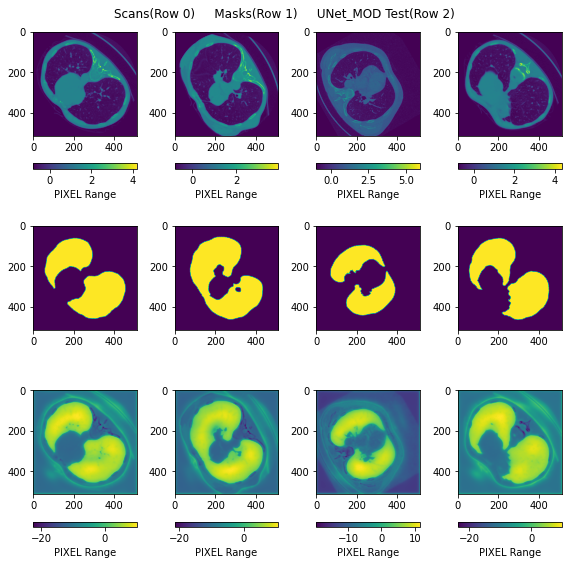

In [ ]:
"""
Step 5: Visualizing network output
"""

# --------- NETWORK IN/OUT TESTING ------- #
fig ,ax = plt.subplots(3,4,figsize=(8,8))
fig.set_tight_layout(True)
fig.suptitle("Scans(Row 0)     Masks(Row 1)     UNet_MOD Test(Row 2)")

for i, data in enumerate(testLoader, 0):

  # Graph 4 instances of the input and label
  if i==4: break
  else:
    inputs, labels = data[0].to(device = DEVICE, dtype = torch.float), data[1].to(device = DEVICE, dtype = torch.float)
    
    output_tensor = model(inputs).cpu().detach()
    # output_tensor = TF.normalize(model(inputs).cpu().detach(), torch.mean(model(inputs).cpu().detach()), torch.std(model(inputs).cpu().detach()))
    # output_tensor = torch.sigmoid(output_tensor)

    label_val =np.squeeze(np.squeeze(np.asarray(labels.cpu().detach().numpy())))
    output =np.squeeze(np.squeeze(np.asarray(output_tensor.numpy())))
    input = np.squeeze(np.squeeze(np.asarray(inputs.cpu().detach().numpy())))

    # --- IMAGE ANALYSIS
    # if i == 3: 
    #   npstats(input, "input ")
    #   npstats(label_val, "label ")

    #   # sig_out = np.squeeze(np.squeeze(np.asarray(torch.sigmoid(model(inputs)).cpu().detach().numpy())))
    #   # npstats(sig_out, "Sigmoid Out")
   
    #   npstats(output, "Pre-thresh Out")

    #   thresh = np.mean(output) + np.abs(.80*output.std())
    #   print(thresh.shape)
    #   # preds[preds > thresh] = 1

    #   output[output >= thresh] = 1.0
    #   output[output < thresh] = 0.0

    #   npstats(output, "Post-thresh Out ")

    # else:
    #   thresh = np.mean(output) + np.abs(.80*output.std())

    #   output[output >= thresh] = 1.0
    #   output[output < thresh] = 0.0
      

    tempPLT1 =                 ax[0][i].imshow(input) 
    plt.colorbar(tempPLT1,ax = ax[0][i],label="PIXEL Range", orientation="horizontal")

    tempPLT2=                  ax[1][i].imshow(label_val)
    # plt.colorbar(tempPLT2,ax = ax[1][i],label="PIXEL Range", orientation="horizontal")

    tempPLT3 =                 ax[2][i].imshow(output)
    plt.colorbar(tempPLT3,ax = ax[2][i],label="PIXEL Range", orientation="horizontal")

# plt.colorbar(tempPLT1,ax =ax[0][3],label="Voxel Range", orientation="horizontal")
# plt.colorbar(tempPLT2,ax =ax[1][3],label="Voxel Range", orientation="horizontal")



### <font color = Maroon> <b> * </b> </font> Saved files - W/Threshold, black and white masks



In [ ]:
# Grab image references from the local files

directorys = ["input/","masks/","preds/"]
ImageReferences = []

print(os.getcwd())

for pwds in directorys:
  # os.chdir('~/content') Home directory
  os.chdir(pwds)
  ImageReferences.append(os.listdir())
  os.chdir(os.pardir)

# Check:
print(ImageReferences)
print(os.getcwd())


/content
[['48.png', '74.png', '176.png', '145.png', '215.png', '13.png', '186.png', '249.png', '184.png', '151.png', '116.png', '166.png', '132.png', '183.png', '136.png', '61.png', '91.png', '5.png', '78.png', '188.png', '314.png', '29.png', '261.png', '130.png', '253.png', '242.png', '40.png', '133.png', '196.png', '193.png', '240.png', '168.png', '201.png', '264.png', '108.png', '140.png', '26.png', '118.png', '86.png', '255.png', '272.png', '125.png', '70.png', '270.png', '76.png', '175.png', '293.png', '147.png', '134.png', '218.png', '155.png', '113.png', '221.png', '143.png', '71.png', '294.png', '198.png', '290.png', '77.png', '259.png', '157.png', '25.png', '189.png', '313.png', '102.png', '131.png', '312.png', '231.png', '117.png', '154.png', '164.png', '165.png', '31.png', '248.png', '266.png', '19.png', '179.png', '200.png', '53.png', '246.png', '305.png', '285.png', '3.png', '141.png', '67.png', '291.png', '159.png', '52.png', '84.png', '278.png', '171.png', '14.png', '21

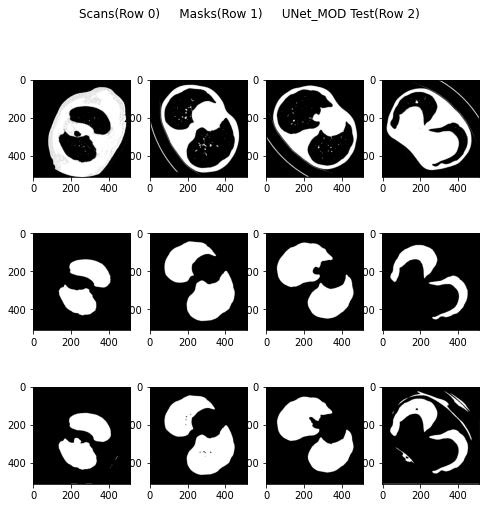

In [ ]:
"""
Step 5: Visualizing file outputs
"""
import matplotlib.image as img

inputs = ImageReferences[0]
masks =  ImageReferences[1]
predictions =  ImageReferences[2]

# Grab the file from the local file folders

fig ,ax = plt.subplots(3,4,figsize=(8,8))
# fig.set_tight_layout(True)
fig.suptitle("Scans(Row 0)     Masks(Row 1)     UNet_MOD Test(Row 2)")

for i in range(4):

  rand_indx = np.random.randint(0,len(testLoader)-1)
  tempIn = img.imread("input/"+inputs[rand_indx])
  tempMask = img.imread("masks/"+masks[rand_indx])
  tempPreds = img.imread("preds/"+predictions[rand_indx])


  ax[0][i].imshow(tempIn) 
  ax[1][i].imshow(tempMask)
  ax[2][i].imshow(tempPreds)


  
